# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [59]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CIFAR-10 Data Loading and Preprocessing

In [60]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape


Training data shape:  (50000L, 32L, 32L, 3L)
Training labels shape:  (50000L,)
Test data shape:  (10000L, 32L, 32L, 3L)
Test labels shape:  (10000L,)


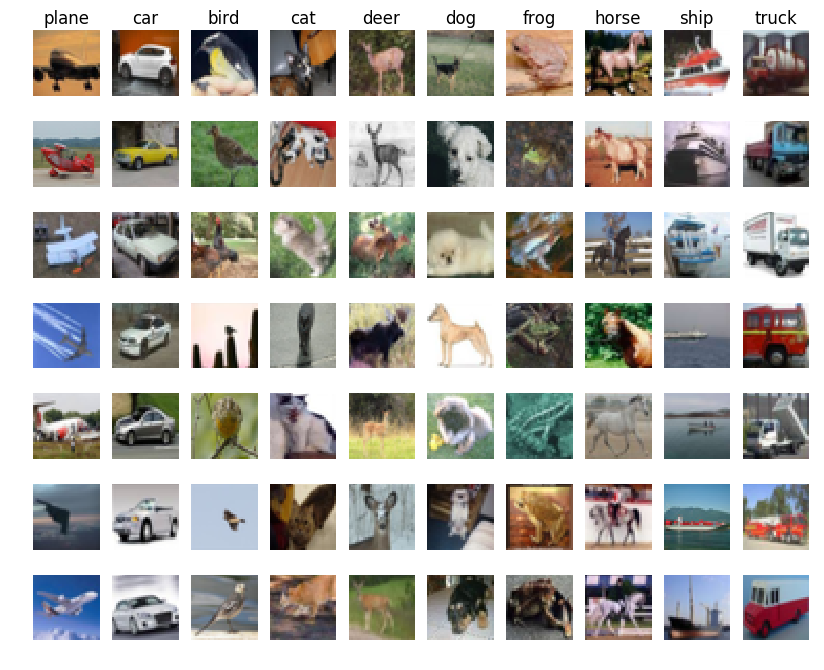

In [61]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [62]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train data shape:  (49000L, 32L, 32L, 3L)
Train labels shape:  (49000L,)
Validation data shape:  (1000L, 32L, 32L, 3L)
Validation labels shape:  (1000L,)
Test data shape:  (1000L, 32L, 32L, 3L)
Test labels shape:  (1000L,)


In [63]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print 'Training data shape: ', X_train.shape
print 'Validation data shape: ', X_val.shape
print 'Test data shape: ', X_test.shape
print 'dev data shape: ', X_dev.shape

Training data shape:  (49000L, 3072L)
Validation data shape:  (1000L, 3072L)
Test data shape:  (1000L, 3072L)
dev data shape:  (500L, 3072L)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


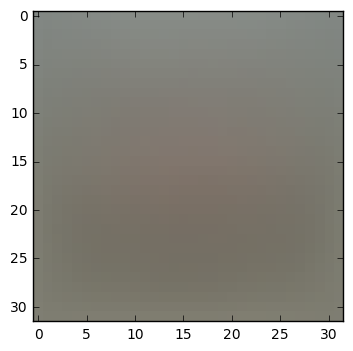

In [64]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print mean_image[:10] # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [65]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [66]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print X_train.shape, X_val.shape, X_test.shape, X_dev.shape

(49000L, 3073L) (1000L, 3073L) (1000L, 3073L) (500L, 3073L)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [67]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm_V1 import svm_loss_naive
import time

# Development code - use a smaller dataset to code svm_loss_naive
# We will first try a training dataset with only 1 data point
X1 = np.random.randn(5, 5)
W1 = np.random.randn(5, 3)
y1 = np.array([1, 2, 0, 0, 1])
S = X1.dot(W1)
print "Training Data:\n"
print X1
print "Parameters:\n"
print W1
print "True Labels:\n"
print y1
print "Score (XW):\n"
print S
loss, grad = svm_loss_naive(W1, X1, y1, 0.0, False)

print "Outputs of svm_loss_naive:\n"
print loss
print grad

# print '\n'+'Numerical gradient calculation' 
# from cs231n.gradient_check import grad_check_sparse
# f = lambda w: svm_loss_naive(W1, X1, y1, 0.0)[0]
# grad_numerical = grad_check_sparse(f, W1, grad, 3)

# Original code
# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.00001, False)
print 'loss: %f' % (loss, )

Training Data:

[[-0.603057    1.59903394 -1.3143628   2.05136145  0.42908579]
 [ 0.22811911 -0.71997117  0.65594041 -0.91670168 -2.65703667]
 [ 1.48878963  0.15135918 -0.05895363 -1.26324783 -0.31292878]
 [-0.76648309 -0.32272069  0.48725101 -0.19468407 -0.82696278]
 [ 0.51361064  0.12013829  1.25518996 -3.01197835  0.74127819]]
Parameters:

[[-1.55852011 -0.36776024  1.44550546]
 [-0.16480556 -1.59400335  0.67150454]
 [-0.54283953 -0.72153186 -0.71403866]
 [-0.01723558 -1.42959817  0.13782392]
 [ 2.7660801   0.71461915  0.81098316]]
True Labels:

[1 2 0 0 1]
Score (XW):

[[  2.54136414e+00  -4.00472008e+00   1.77125023e+00]
 [ -7.92671974e+00   2.20714879e-03  -2.90323870e+00]
 [ -3.15706431e+00   8.36064145e-01   1.86790136e+00]
 [ -1.30082342e+00   1.32089297e-01  -2.37006496e+00]
 [  6.00709339e-01   3.54960438e+00   1.12887709e-01]]
Outputs of svm_loss_naive:

6.33570144835
[[-0.56283063  0.43130793  0.13152271]
 [ 0.32380725 -0.81788011  0.49407286]
 [-0.33674131  0.74259268 -0.

The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [68]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0, False)

print "Run #1 - w/o Regularization"
# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0, False)[0]
grad_numerical = grad_check_sparse(f, W, grad)

print "Run #2 - w/ Regularization"
# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.5, False)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.5, False)[0]
grad_numerical = grad_check_sparse(f, W, grad)

Run #1 - w/o Regularization
numerical: 1.086312 analytic: 1.086312, relative error: 1.584332e-11
numerical: -23.967249 analytic: -23.967249, relative error: 5.767708e-13
numerical: 14.512673 analytic: 14.512673, relative error: 1.351973e-12
numerical: 2.370324 analytic: 2.370324, relative error: 8.628112e-12
numerical: 16.906568 analytic: 16.906568, relative error: 3.267017e-12
numerical: -8.865606 analytic: -8.865606, relative error: 5.460947e-13
numerical: 9.425910 analytic: 9.425910, relative error: 1.786645e-12
numerical: -29.406166 analytic: -29.486361, relative error: 1.361724e-03
numerical: -29.601751 analytic: -29.601751, relative error: 1.606608e-12
numerical: 0.252222 analytic: 0.252222, relative error: 1.012704e-10
Run #2 - w/ Regularization
numerical: 12.714560 analytic: 12.714560, relative error: 1.466121e-12
numerical: 7.525171 analytic: 7.525171, relative error: 4.713494e-12
numerical: -3.888213 analytic: -3.888213, relative error: 9.216289e-12
numerical: 27.837726 analy

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

In [80]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0)
toc = time.time()
print 'Naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.linear_svm_V1 import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0)
toc = time.time()
print 'Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# The losses should match but your vectorized implementation should be much faster.
print 'difference: %f' % (loss_naive - loss_vectorized)

Naive loss: 8.611650e+00 computed in 0.063000s
Vectorized loss: 8.611650e+00 computed in 0.005000s
difference: 0.000000


In [81]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.5)
toc = time.time()
print 'Naive loss and gradient: computed in %fs' % (toc - tic)

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.5)
toc = time.time()
print 'Vectorized loss and gradient: computed in %fs' % (toc - tic)

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'difference: %f' % difference

Naive loss and gradient: computed in 0.055000s
Vectorized loss and gradient: computed in 0.004000s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [84]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=False)
toc = time.time()
print 'That took %fs' % (toc - tic)

That took 9.742000s


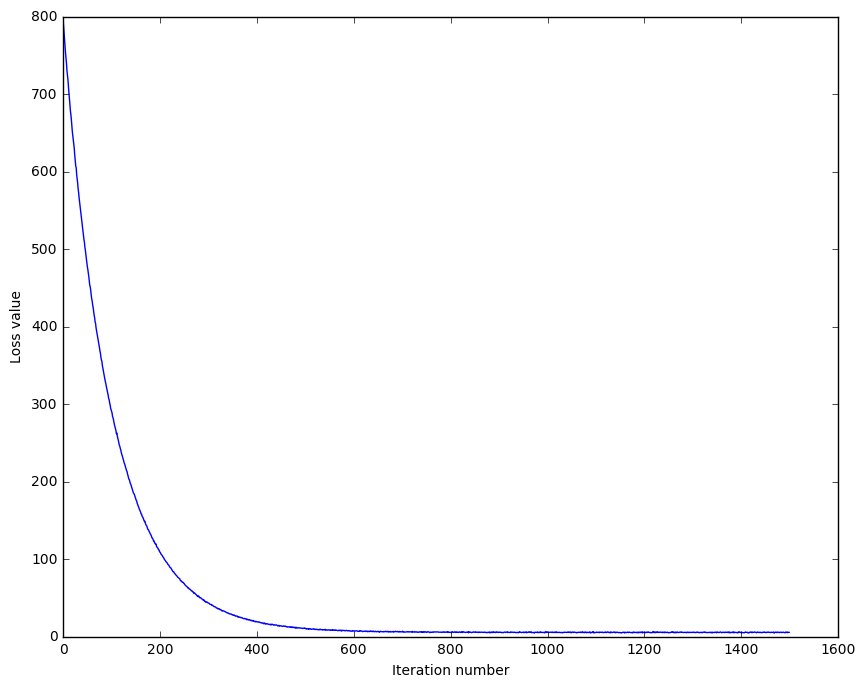

In [85]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [99]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set

y_train_pred = svm.predict(X_train)

print y_train[:10]  # Debug printout
print y_train_pred[:10]  # Debug printout

print 'training accuracy: %f' % (np.mean(y_train == y_train_pred), )
y_val_pred = svm.predict(X_val)
print 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), )

[6 9 9 4 1 1 2 7 8 3]
[6 8 9 6 8 6 4 7 8 9]
training accuracy: 0.374449
validation accuracy: 0.387000


In [124]:
from cs231n.classifiers import LinearSVM

# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [5e-8, 1e-7, 2e-7, 3e-7, 4e-7]
regularization_strengths = [4e3, 5e3, 6e3, 8e3, 1e4, 2e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
for learning_rate in learning_rates:
    for reg in regularization_strengths:
    
        # Train the SVM model using training data
        svm = LinearSVM()
        tic = time.time()
        loss_hist = svm.train(X_train, y_train, learning_rate, reg,
                      num_iters=1500, verbose=False)

        # Evaluate performance on training and validation data  
        y_train_pred = svm.predict(X_train)
        y_val_pred = svm.predict(X_val)
        train_accuracy = np.mean(y_train == y_train_pred)
        val_accuracy = np.mean(y_val == y_val_pred)
        
        results[(learning_rate, reg)]=(train_accuracy,val_accuracy)
        
        if (val_accuracy > best_val):
            best_val = val_accuracy
            best_svm = svm
            best_hparam = (learning_rate, reg)
            
        # Output results
        print 'Learning rate is %e' % learning_rate
        print 'Regularization Strength is %d' % reg
        print 'training accuracy: %f' % train_accuracy
        print 'validation accuracy: %f' % val_accuracy  
        toc = time.time()
        print 'That took %fs' % (toc - tic)
        
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val
print 'hyperparameters (learning_rate, reg) are %s' % (best_hparam,)

Learning rate is 5.000000e-08
Regularization Strength is 4000
training accuracy: 0.296306
validation accuracy: 0.306000
That took 10.628000s
Learning rate is 5.000000e-08
Regularization Strength is 5000
training accuracy: 0.298449
validation accuracy: 0.311000
That took 10.061000s
Learning rate is 5.000000e-08
Regularization Strength is 6000
training accuracy: 0.309592
validation accuracy: 0.309000
That took 9.919000s
Learning rate is 5.000000e-08
Regularization Strength is 8000
training accuracy: 0.309796
validation accuracy: 0.311000
That took 9.936000s
Learning rate is 5.000000e-08
Regularization Strength is 10000
training accuracy: 0.313857
validation accuracy: 0.324000
That took 10.003000s
Learning rate is 5.000000e-08
Regularization Strength is 20000
training accuracy: 0.357306
validation accuracy: 0.353000
That took 9.864000s
Learning rate is 1.000000e-07
Regularization Strength is 4000
training accuracy: 0.335633
validation accuracy: 0.337000
That took 9.849000s
Learning rate i

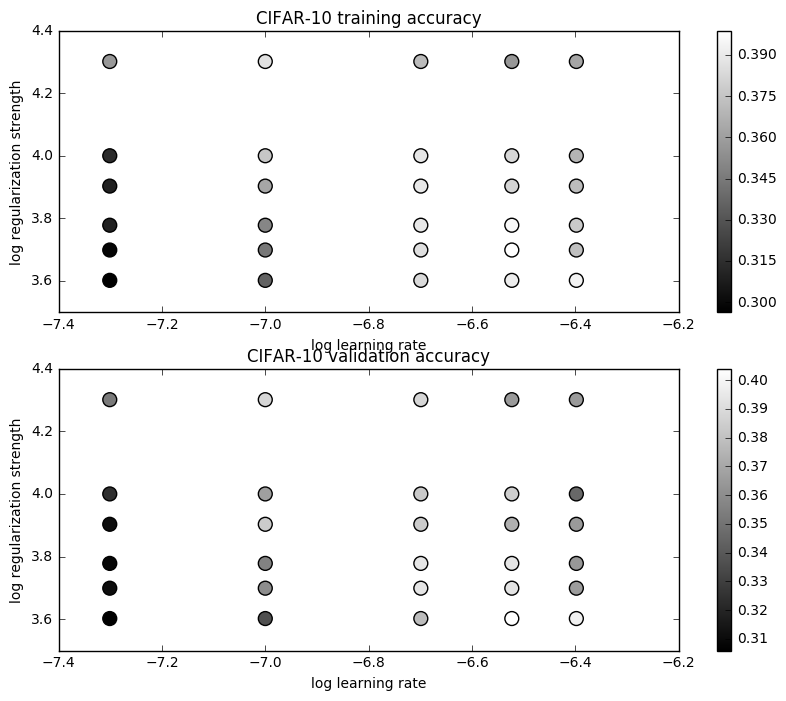

In [125]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [126]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'linear SVM on raw pixels final test set accuracy: %f' % test_accuracy

linear SVM on raw pixels final test set accuracy: 0.376000


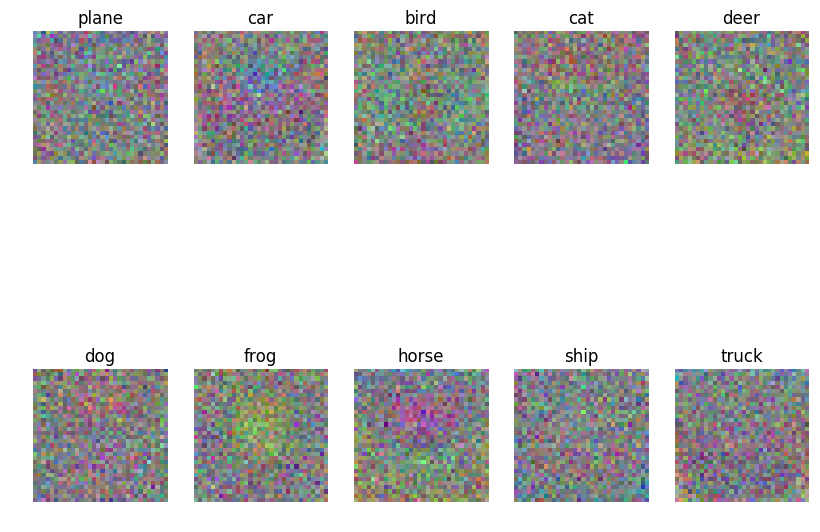

In [127]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*